<a href="https://colab.research.google.com/github/Yejide123/Nigeria-2023_Multi_Sentiment_analysis_Project/blob/main/Project_RoBERTa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/drive') #  mount google drive for access to file

path = "/content/drive/MyDrive/Project_codes/train_labelled_data.csv" # read in the labelled data for the purpose of training
train_data = pd.read_csv(path)

Mounted at /content/drive


In [ ]:
train_data

,Unnamed: 0,text,cleaned_text,scores,label
0,0,#OBI and #wife storm kastina state today.\n\nS...,wife storm kastina state todaysee crowd nigeri...,0.6249,positive
1,1,"If they can’t point to you one project , inves...",can ’ t point one project investment vision le...,0.2500,positive
2,2,@atiku God with his infinite mercy will never ...,god infinite mercy never allow emerge presiden...,-0.6874,negative
3,3,Governor @RotimiAkeredolu takes Asiwaju Bola A...,rotimiakeredolu take asiwaju bola ahmed tinubu...,0.0000,neutral
4,4,@atiku Salutation is not Love. #Obi is coming,salutation love obi come,0.6369,positive
...,...,...,...,...,...
62137,74558,"I wish to convey my sympathies to the victims,...",wish convey sympathy victim gov zulum shehu bo...,0.4767,positive
62138,74559,I received with great sadness reports of the r...,receive great sadness report raze popular maid...,0.3818,positive
62139,74560,My deepest condolences to his family and the F...,deep condolence family fct pdp family may soul...,0.5423,positive
62140,74561,Hon Sunday Zaka truly embodied the Recovery sp...,sunday zaka truly embody recovery spirit pdp e...,0.5574,positive


In [ ]:
# Install necessary libraries
!pip install torch
!pip install transformers
!pip install scikit-learn

# Import libraries

import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW, Trainer, TrainingArguments
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# Set device (GPU if available, else CPU)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# convert 'labels' from strings to numbers(encoding the label)
label_encoder = LabelEncoder()
train_data['label'] = label_encoder.fit_transform(train_data['label'])
# Split the data into train and test sets
train_data, test_data = train_test_split(train_data, test_size=0.2, random_state=42)

# Define the dataset class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            return_tensors="pt",
            truncation=True,
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "label": torch.tensor(label, dtype=torch.long),
        }

# Create the tokenizer and ROBERTa model from the pretrained model

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=3) # reference 3 categorical data of labels
model.to(device) # pytorch method to move the model parameters

# Create dataloaders ( train and test data using the defined class)
train_dataset = SentimentDataset(
    texts=train_data["cleaned_text"].values,
    labels=train_data["label"].values,
    tokenizer=tokenizer,
)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

test_dataset = SentimentDataset(
    texts=test_data["cleaned_text"].values,
    labels=test_data["label"].values,
    tokenizer=tokenizer,
)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Configure optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5) # defining the optimizer with the learning rate
criterion = torch.nn.CrossEntropyLoss()

# Training loop
num_epochs = 3 # number of cycles the model processed the trained data
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        inputs = {k: v.to(device) for k, v in batch.items() if k != "label"}
        labels = batch["label"].to(device)
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

# Evaluation of the model using test data
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch in test_loader:
        inputs = {k: v.to(device) for k, v in batch.items() if k != "label"}
        labels = batch["label"].to(device)
        outputs = model(**inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())





vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Print classification report
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      2389
           1       0.99      0.94      0.96      4723
           2       0.96      0.98      0.97      5317

    accuracy                           0.96     12429
   macro avg       0.95      0.95      0.95     12429
weighted avg       0.96      0.96      0.96     12429



In [ ]:
# Use the model for predictions on sample data to caputre the translation of the predicted output (coded in numbers)
new_texts = ["Happy", "Sad", "Okay"]
new_dataset = SentimentDataset(
    texts=new_texts,
    labels=[0, 1, 2],  # Replace with actual labels for new data
    tokenizer=tokenizer,
)
new_loader = DataLoader(new_dataset, batch_size=8, shuffle=False)

model.eval()
new_preds = []
with torch.no_grad():
    for batch in new_loader:
        inputs = {k: v.to(device) for k, v in batch.items() if k != "label"}
        outputs = model(**inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        new_preds.extend(preds.cpu().numpy())

# Display predictions for new data
for text, pred in zip(new_texts, new_preds):
    print(f"Text: {text}, Predicted Label: {pred}")


Text: Happy, Predicted Label: 2
Text: Sad, Predicted Label: 0
Text: Okay, Predicted Label: 2


In [ ]:
import pandas as pd
import numpy as np
# Use the model for predictions on Tinubu's data
path =  '/content/drive/MyDrive/Project_codes/Tinubu_cleaned_dataset.csv'
Tinubu_data = pd.read_csv(path) #  read in Tinubu's processed data


Tinubu_data = Tinubu_data.replace(np.nan, '', regex=True)
Tinubu_text = Tinubu_data['cleaned_text'].tolist() #  capture the cleaned_text column and convert to list

new_dataset = SentimentDataset(
    texts=Tinubu_text,
    labels=[0] * len(Tinubu_text),
    tokenizer=tokenizer,
)
new_loader = DataLoader(new_dataset, batch_size=8, shuffle=False) #  get the processed data into required format using the defined dataloader
#  get the predicted sentiments for each of the text in the data
model.eval()
new_preds = []
with torch.no_grad():
    for batch in new_loader:
        inputs = {k: v.to(device) for k, v in batch.items() if k != "label"}
        outputs = model(**inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        new_preds.extend(preds.cpu().numpy())



In [ ]:
Tinubu_data

,Unnamed: 0,Tweet_Text,cleaned_text
0,0,"b'RT @kc_journalist: Elder Statesman, Tanko Ya...",elder statesman tanko yakassai drop bomb tinub...
1,2,b'RT @novieverest: I have said it if APC had s...,say apc single dirt peter obi would easily use...
2,6,"b""RT @DavidHundeyin: On election day, come out...",election day come large group tinubus hooligan...
3,7,b'RT @KadunaResident: Peter Obi has taught Agb...,peter obi teach agbado tinubu show street cred...
4,8,b'RT @PeterObi: Our most profound and heartfel...,profound heartfelt appreciation go people lago...
...,...,...,...
176623,2000217,"b""RT @usmanlade: Peter Obi Vs Asiwaju Rally in...",peter obi vs asiwaju rally kwara venue e didnt...
176624,2000227,"b'Vote Peter obi of #LP for a new Nigeria, dem...",peter obi lp new nigeria democracy politics pe...
176625,2000232,b'@AdaAnambra2023 The words on the streets now...,word street fuel nd naira note scarcity plot s...
176626,2000235,"b'RT @mrcow_enang: Las las, we will get sense ...",la las get sense force day presidential electi...


In [ ]:
# decoding the sentiments (change from numbers to text)
Tinubu_Predict_label = [] #  create an empty list to store the decoded sentiments
for code_label in new_preds:
  if code_label == 0: #  0 is equal to negative
    Tinubu_Predict_label.append('Negative')
  elif code_label == 1:
    Tinubu_Predict_label.append('Neutral') #  1 equal neutral
  elif code_label == 2:
    Tinubu_Predict_label.append('Positive') #  2 equal  positive

Tinubu_Predict_label

['Negative',
 'Negative',
 'Negative',
 'Positive',
 'Positive',
 'Positive',
 'Negative',
 'Neutral',
 'Neutral',
 'Neutral',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Neutral',
 'Negative',
 'Negative',
 'Positive',
 'Neutral',
 'Negative',
 'Positive',
 'Negative',
 'Neutral',
 'Positive',
 'Positive',
 'Positive',
 'Negative',
 'Neutral',
 'Positive',
 'Positive',
 'Positive',
 'Negative',
 'Positive',
 'Negative',
 'Neutral',
 'Positive',
 'Negative',
 'Negative',
 'Negative',
 'Positive',
 'Neutral',
 'Positive',
 'Neutral',
 'Negative',
 'Negative',
 'Positive',
 'Positive',
 'Neutral',
 'Neutral',
 'Positive',
 'Negative',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Neutral',
 'Neutral',
 'Negative',
 'Neutral',
 'Neutral',
 'Negative',
 'Neutral',
 'Negative',
 'Positive',
 'Neutral',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Negative',
 'Negative',
 'Negative',
 'Positive',
 'Neutral',
 'Positive',
 'Neutral',
 'Nega

In [ ]:
Tinubu_data['Predicted_Label'] = Tinubu_Predict_label #  append the list of the sentiments to the Tinubu data

In [ ]:
Tinubu_data # output information

,Unnamed: 0,Tweet_Text,cleaned_text,Predicted_Label
0,0,"b'RT @kc_journalist: Elder Statesman, Tanko Ya...",elder statesman tanko yakassai drop bomb tinub...,Negative
1,2,b'RT @novieverest: I have said it if APC had s...,say apc single dirt peter obi would easily use...,Negative
2,6,"b""RT @DavidHundeyin: On election day, come out...",election day come large group tinubus hooligan...,Negative
3,7,b'RT @KadunaResident: Peter Obi has taught Agb...,peter obi teach agbado tinubu show street cred...,Positive
4,8,b'RT @PeterObi: Our most profound and heartfel...,profound heartfelt appreciation go people lago...,Positive
...,...,...,...,...
176623,2000217,"b""RT @usmanlade: Peter Obi Vs Asiwaju Rally in...",peter obi vs asiwaju rally kwara venue e didnt...,Positive
176624,2000227,"b'Vote Peter obi of #LP for a new Nigeria, dem...",peter obi lp new nigeria democracy politics pe...,Neutral
176625,2000232,b'@AdaAnambra2023 The words on the streets now...,word street fuel nd naira note scarcity plot s...,Negative
176626,2000235,"b'RT @mrcow_enang: Las las, we will get sense ...",la las get sense force day presidential electi...,Positive


In [ ]:
Tinubu_data['Predicted_Label'].value_counts()

Positive    84711
Negative    54487
Neutral     37430
Name: Predicted_Label, dtype: int64

<Axes: title={'center': 'TINUBU RoBERTa SENTIMENT ANALYSIS'}>

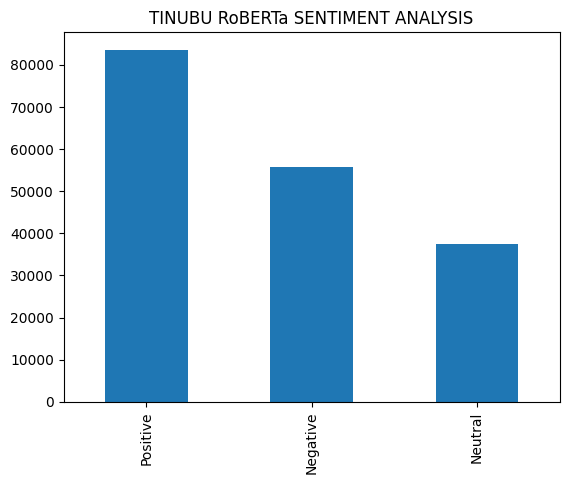

In [ ]:
Tinubu_data['Predicted_Label'].value_counts().plot(kind ='bar', title = 'TINUBU RoBERTa SENTIMENT ANALYSIS') #Plot sentiment analysis graph for Tinubu

In [ ]:
Tinubu_data.to_csv('/content/drive/MyDrive/Project_codes/ROBERT_output_tinubu.csv') #save Tinubu's sentiment details to Project

In [ ]:
# Use the model for predictions on Obi's data
path =  '/content/drive/MyDrive/Project_codes/Obi_cleaned_dataset.csv'
Obi_data = pd.read_csv(path) # access the processed Obi data


Obi_data = Obi_data.replace(np.nan, '', regex=True)
Obi_text = Obi_data['cleaned_text'].tolist() # capture the cleaned_text column and convert to list

 # convert the processed data to the required format
new_dataset = SentimentDataset(
    texts=Obi_text,
    labels=[0] * len(Obi_text),
    tokenizer=tokenizer,
)
new_loader = DataLoader(new_dataset, batch_size=8, shuffle=False)

 # Generate the predicted sentiments
model.eval()
Obi_new_preds = []
with torch.no_grad():
    for batch in new_loader:
        inputs = {k: v.to(device) for k, v in batch.items() if k != "label"}
        outputs = model(**inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        Obi_new_preds.extend(preds.cpu().numpy())

In [ ]:
 # Decode the predicted sentiments from numbers to text
Obi_Predict_label = []
for code_label in Obi_new_preds:
  if code_label == 0:
    Obi_Predict_label.append('Negative')
  elif code_label == 1:
    Obi_Predict_label.append('Neutral')
  elif code_label == 2:
    Obi_Predict_label.append('Positive')

Obi_Predict_label

['Negative',
 'Positive',
 'Negative',
 'Negative',
 'Positive',
 'Positive',
 'Neutral',
 'Positive',
 'Positive',
 'Negative',
 'Neutral',
 'Neutral',
 'Negative',
 'Positive',
 'Positive',
 'Positive',
 'Negative',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Negative',
 'Neutral',
 'Negative',
 'Negative',
 'Positive',
 'Neutral',
 'Neutral',
 'Positive',
 'Negative',
 'Negative',
 'Positive',
 'Positive',
 'Positive',
 'Neutral',
 'Positive',
 'Neutral',
 'Positive',
 'Positive',
 'Negative',
 'Neutral',
 'Positive',
 'Positive',
 'Negative',
 'Positive',
 'Positive',
 'Negative',
 'Negative',
 'Neutral',
 'Positive',
 'Neutral',
 'Negative',
 'Negative',
 'Negative',
 'Positive',
 'Neutral',
 'Negative',
 'Negative',
 'Positive',
 'Neutral',
 'Negative',
 'Neutral',
 'Negative',
 'Negative',
 'Negative',
 'Positive',
 'Positive',
 'Neutral',
 'Neutral',
 'Neutral',
 'Negative',
 'Positive',
 'Positive',
 'Neutral',
 'Neutral',
 'Negative',
 'Positive',
 'Positive',
 'Neu

In [ ]:
Obi_data

,Unnamed: 0,Tweet_Text,cleaned_text
0,2,b'RT @novieverest: I have said it if APC had s...,say apc single dirt peter obi would easily use...
1,3,b'RT @Mario9jaa: FUN FACT: He is now supportin...,fun fact support obi
2,4,b'RT @MimiUhiene: the most dangerous kidnappe...,dangerous kidnapper anambra peter obi governor...
3,5,b'RT @sheni_coker: Peter Obi has done his part...,peter obi do part onus u go massively vote may...
4,7,b'RT @KadunaResident: Peter Obi has taught Agb...,peter obi teach agbado tinubu show street cred...
...,...,...,...
223657,2000212,b'@dondekojo First choice: Obi Second choice: ...,first choice obi second choice obi third choic...
223658,2000216,b'@victorhabila121 @PodiumReporters @DeeOneAye...,podiumreporters deeoneayekooto peterobi tinubu...
223659,2000217,"b""RT @usmanlade: Peter Obi Vs Asiwaju Rally in...",peter obi vs asiwaju rally kwara venue e didnt...
223660,2000227,"b'Vote Peter obi of #LP for a new Nigeria, dem...",peter obi lp new nigeria democracy politics pe...


In [ ]:
Obi_data['Predicted_Label'] = Obi_Predict_label  # add the list of the decoded predicted sentiments to Obi data

In [ ]:
Obi_data


,Unnamed: 0,Tweet_Text,cleaned_text,Predicted_Label
0,2,b'RT @novieverest: I have said it if APC had s...,say apc single dirt peter obi would easily use...,Negative
1,3,b'RT @Mario9jaa: FUN FACT: He is now supportin...,fun fact support obi,Positive
2,4,b'RT @MimiUhiene: the most dangerous kidnappe...,dangerous kidnapper anambra peter obi governor...,Negative
3,5,b'RT @sheni_coker: Peter Obi has done his part...,peter obi do part onus u go massively vote may...,Negative
4,7,b'RT @KadunaResident: Peter Obi has taught Agb...,peter obi teach agbado tinubu show street cred...,Positive
...,...,...,...,...
223657,2000212,b'@dondekojo First choice: Obi Second choice: ...,first choice obi second choice obi third choic...,Neutral
223658,2000216,b'@victorhabila121 @PodiumReporters @DeeOneAye...,podiumreporters deeoneayekooto peterobi tinubu...,Positive
223659,2000217,"b""RT @usmanlade: Peter Obi Vs Asiwaju Rally in...",peter obi vs asiwaju rally kwara venue e didnt...,Positive
223660,2000227,"b'Vote Peter obi of #LP for a new Nigeria, dem...",peter obi lp new nigeria democracy politics pe...,Neutral


In [ ]:
Obi_data['Predicted_Label'].value_counts()

Positive    108492
Negative     61948
Neutral      53222
Name: Predicted_Label, dtype: int64

<Axes: title={'center': 'Obi RoBERTa SENTIMENT ANALYSIS'}>

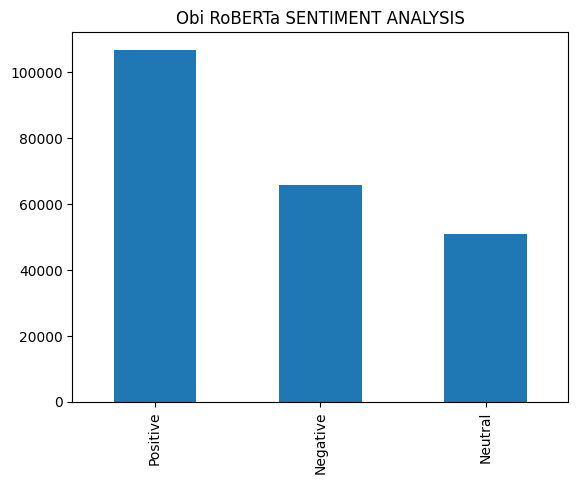

In [ ]:
Obi_data['Predicted_Label'].value_counts().plot(kind ='bar', title = 'Obi RoBERTa SENTIMENT ANALYSIS')  # Plot the graph for the sentiments of OBI's data

In [ ]:
# Use the model for predictions on Atiku's data
path =  '/content/drive/MyDrive/Project_codes/Atiku_cleaned_dataset.csv'
Atiku_data = pd.read_csv(path) # access the processed Atiku data


Atiku_data = Atiku_data.replace(np.nan, '', regex=True)
Atiku_text = Atiku_data['cleaned_text'].tolist() # capture the cleaned_text column and convert to list

#  Convert the list of the cleaned data to the required format for the model
new_dataset = SentimentDataset(
    texts=Atiku_text,
    labels=[0] * len(Atiku_text),
    tokenizer=tokenizer,
)
new_loader = DataLoader(new_dataset, batch_size=8, shuffle=False)

#  Generate the predicted sentiments for Atiku using the model
model.eval()
Atiku_new_preds = []
with torch.no_grad():
    for batch in new_loader:
        inputs = {k: v.to(device) for k, v in batch.items() if k != "label"}
        outputs = model(**inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        Atiku_new_preds.extend(preds.cpu().numpy())

In [ ]:
# Decode the generated list of the predicted sentiments
Atiku_Predict_label = []
for code_label in Atiku_new_preds:
  if code_label == 0:
    Atiku_Predict_label.append('Negative')
  elif code_label == 1:
    Atiku_Predict_label.append('Neutral')
  elif code_label == 2:
    Atiku_Predict_label.append('Positive')

Atiku_Predict_label

['Negative',
 'Positive',
 'Positive',
 'Negative',
 'Negative',
 'Positive',
 'Neutral',
 'Neutral',
 'Positive',
 'Negative',
 'Positive',
 'Positive',
 'Negative',
 'Neutral',
 'Negative',
 'Neutral',
 'Positive',
 'Negative',
 'Neutral',
 'Positive',
 'Positive',
 'Neutral',
 'Neutral',
 'Negative',
 'Positive',
 'Positive',
 'Neutral',
 'Neutral',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Positive',
 'Negative',
 'Positive',
 'Negative',
 'Negative',
 'Neutral',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Neutral',
 'Neutral',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Neutral',
 'Neutral',
 'Positive',
 'Positive',
 'Negative',
 'Neutral',
 'Negative',
 'Negative',
 'Neutral',
 'Positive',
 'Negative',
 'Positive',
 'Negative',
 'Negative',
 'Positive',
 'Positive',
 'Neutral',
 'Negative',
 'Positive',
 'Positive',
 'Positive',
 'Negative',
 'Neutral',
 'Positive',
 'Negative',
 'Positive',
 'Ne

In [ ]:
Atiku_data

,Unnamed: 0,Tweet_Text,cleaned_text
0,0,"b'RT @kc_journalist: Elder Statesman, Tanko Ya...",elder statesman tanko yakassai drop bomb tinub...
1,38,b'RT @EstherOkokon3: @DailyPostNGR But you Kwa...,dailypostngr kwankwaso win without merge nah w...
2,52,b'@asconambassador The first time vote out APC...,first time vote apc 2019 best time 2023 yoruba...
3,60,b'RT @MimiUhiene: Atiku Won\xe2\x80\x99t Win B...,atiku wont win 22 apc governor 5 pdp governor ...
4,95,b'RT @VictorIsrael_: Tinubu went to his campai...,tinubu go campaign rally insult peter obi danc...
...,...,...,...
31849,1999957,b'No poll has projected APC to win the 2023 el...,poll project apc win 2023 election anap poll p...
31850,1999990,"b'@atiku As The Wings Of The Unifier, #AtikuYo...",wing unifier atikuyouthwing tell fact bauchi s...
31851,2000016,"b""@HAHayatu North expecially core North has al...",north ecially core north always power hungry d...
31852,2000065,b'#Trending: Inec to Postpone Election | Insec...,inec postpone election insecurity click watch ...


In [ ]:
Atiku_data['Predicted_Label'] = Atiku_Predict_label # Add the list of the decoded  predicted sentiments to Atiku's data

In [ ]:
Atiku_data

,Unnamed: 0,Tweet_Text,cleaned_text,Predicted_Label
0,0,"b'RT @kc_journalist: Elder Statesman, Tanko Ya...",elder statesman tanko yakassai drop bomb tinub...,Negative
1,38,b'RT @EstherOkokon3: @DailyPostNGR But you Kwa...,dailypostngr kwankwaso win without merge nah w...,Positive
2,52,b'@asconambassador The first time vote out APC...,first time vote apc 2019 best time 2023 yoruba...,Positive
3,60,b'RT @MimiUhiene: Atiku Won\xe2\x80\x99t Win B...,atiku wont win 22 apc governor 5 pdp governor ...,Negative
4,95,b'RT @VictorIsrael_: Tinubu went to his campai...,tinubu go campaign rally insult peter obi danc...,Negative
...,...,...,...,...
31849,1999957,b'No poll has projected APC to win the 2023 el...,poll project apc win 2023 election anap poll p...,Positive
31850,1999990,"b'@atiku As The Wings Of The Unifier, #AtikuYo...",wing unifier atikuyouthwing tell fact bauchi s...,Neutral
31851,2000016,"b""@HAHayatu North expecially core North has al...",north ecially core north always power hungry d...,Negative
31852,2000065,b'#Trending: Inec to Postpone Election | Insec...,inec postpone election insecurity click watch ...,Negative


In [ ]:
Atiku_data['Predicted_Label'].value_counts()

Positive    16162
Negative    10000
Neutral      5692
Name: Predicted_Label, dtype: int64

<Axes: title={'center': 'Atiku RoBERTa SENTIMENT ANALYSIS'}>

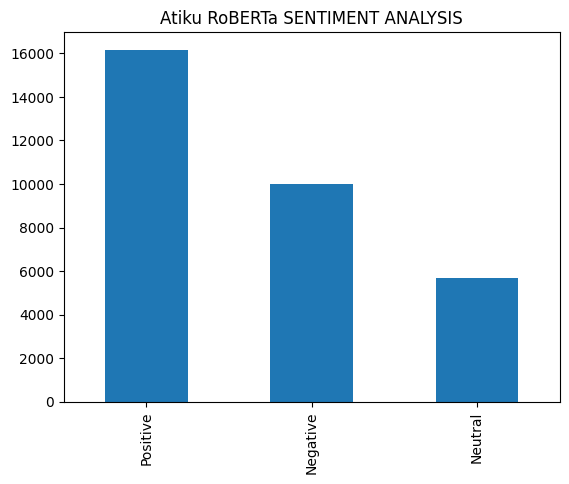

In [ ]:
Atiku_data['Predicted_Label'].value_counts().plot(kind ='bar', title = 'Atiku RoBERTa SENTIMENT ANALYSIS') # Plot the graph for the Atiku sentiments' output

Comparative Analysis of the three presidential candidates (Tinubu, Obi and Atiku)** **bold text**bold text**

In [ ]:
# Get the count of the category of Obi's  sentiment's output
Obi_predicted_count = Obi_data['Predicted_Label'].value_counts()
Obi_data['Predicted_Label'].value_counts()

Positive    108492
Negative     61948
Neutral      53222
Name: Predicted_Label, dtype: int64

In [ ]:
# Get the count of the category of Tinubu's  sentiment's output
Tinubu_predicted_count = Tinubu_data['Predicted_Label'].value_counts()
Tinubu_data['Predicted_Label'].value_counts()

In [ ]:
# Get the count of the category of Atiku's  sentiment's output
Atiku_predicted_count = Atiku_data['Predicted_Label'].value_counts()
Atiku_data['Predicted_Label'].value_counts()

Positive    16579
Negative     9296
Neutral      5979
Name: Predicted_Label, dtype: int64

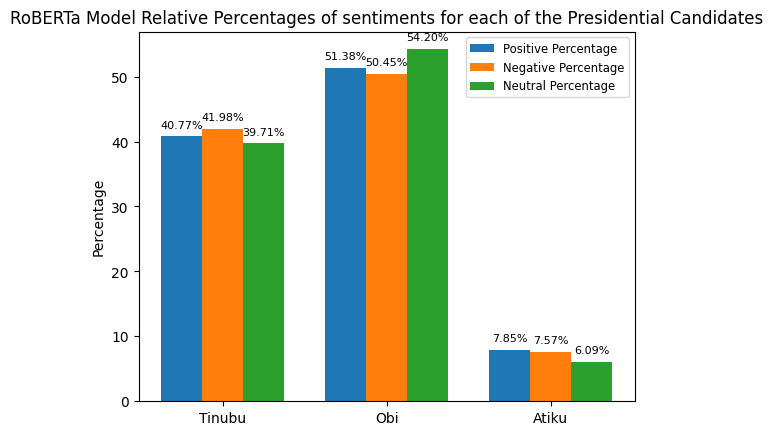

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#CREATE AN EMPTY LIST TO CAPUTRE THE NAMES OF THE CANDIDATES
labels = ['Tinubu', 'Obi', 'Atiku']
categories = ['Positive', 'Negative', 'Neutral']

# Counts for each category within each Candidates
data = np.array([
    [Tinubu_predicted_count['Positive'], Tinubu_predicted_count['Negative'], Tinubu_predicted_count['Neutral']],  # Tinubu
    [Obi_predicted_count['Positive'], Obi_predicted_count['Negative'], Obi_predicted_count['Neutral']],  #Obi
    [Atiku_predicted_count['Positive'], Atiku_predicted_count['Negative'], Atiku_predicted_count['Neutral']],  # Atiku
])

# Calculate overall counts for each category
overall_category_counts = np.sum(data, axis=0)

# Calculate relative percentages
relative_percentages = (data / overall_category_counts) * 100

# Plotting
fig, ax = plt.subplots()

# Plot stacked bar chart
bar_width = 0.25
bar_positions = np.arange(len(labels))

for i, category in enumerate(categories):
    ax.bar(bar_positions + i * bar_width, relative_percentages[:, i], width=bar_width, label=f'{category} Percentage')

# Modifying the bar abd legends labels
ax.set_ylabel('Percentage')
ax.set_title('RoBERTa Model Relative Percentages of sentiments for each of the Presidential Candidates')
ax.set_xticks(bar_positions + (len(categories) - 1) * bar_width / 2)
ax.set_xticklabels(labels)
legend = ax.legend(fontsize='small', bbox_to_anchor=(1, 1))  # Adjust bbox_to_anchor to position the legend

# Display percentages on top of bars with reduced font size
for i, bar_position in enumerate(bar_positions):
    for j, category in enumerate(categories):
        yval = relative_percentages[i, j]
        ax.text(bar_position + j * bar_width, yval + 1, f'{yval:.2f}%', ha='center', va='bottom', fontsize=8)

plt.show()


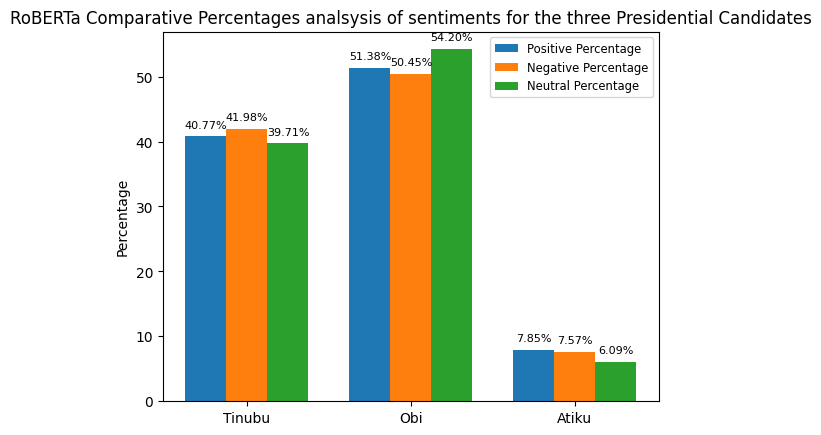

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# CREATE A LIST TO CAPUTRE THE NAMES OF THE CANDIDATES
labels = ['Tinubu', 'Obi', 'Atiku']
categories = ['Positive', 'Negative', 'Neutral']

# Counts for each category within each Candidates
data = np.array([
    [Tinubu_predicted_count['Positive'], Tinubu_predicted_count['Negative'], Tinubu_predicted_count['Neutral']],  # Tinubu
    [Obi_predicted_count['Positive'], Obi_predicted_count['Negative'], Obi_predicted_count['Neutral']],  #Obi
    [Atiku_predicted_count['Positive'], Atiku_predicted_count['Negative'], Atiku_predicted_count['Neutral']],  # Atiku
])

# Calculate overall counts for each category
overall_category_counts = np.sum(data, axis=0)

# Calculate relative percentages
relative_percentages = (data / overall_category_counts) * 100

# Plotting
fig, ax = plt.subplots()

# Plot stacked bar chart
bar_width = 0.25
bar_positions = np.arange(len(labels))

for i, category in enumerate(categories):
    ax.bar(bar_positions + i * bar_width, relative_percentages[:, i], width=bar_width, label=f'{category} Percentage')

# Modifying the bar abd legends labels
ax.set_ylabel('Percentage')
ax.set_title('RoBERTa Comparative Percentages analsysis of sentiments for the three Presidential Candidates')
ax.set_xticks(bar_positions + (len(categories) - 1) * bar_width / 2)
ax.set_xticklabels(labels)
legend = ax.legend(fontsize='small', bbox_to_anchor=(1, 1))  # Adjust bbox_to_anchor to position the legend

# Display percentages on top of bars with reduced font size
for i, bar_position in enumerate(bar_positions):
    for j, category in enumerate(categories):
        yval = relative_percentages[i, j]
        ax.text(bar_position + j * bar_width, yval + 1, f'{yval:.2f}%', ha='center', va='bottom', fontsize=8)

plt.show()

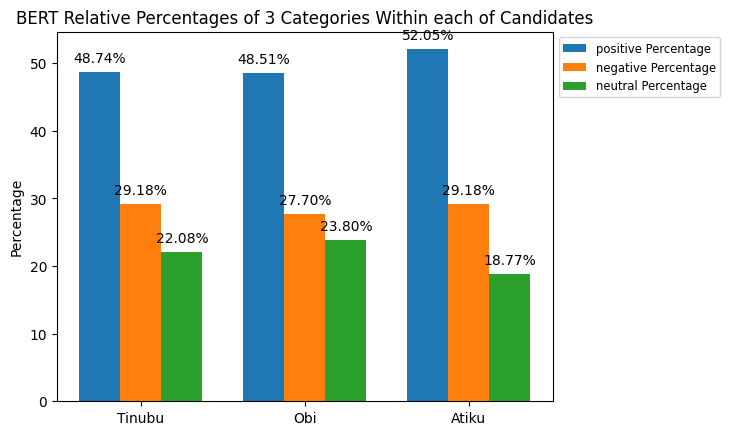

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#Assign the names of the candidates to form a list
labels = ['Tinubu', 'Obi', 'Atiku']
categories = ['positive', 'negative', 'neutral']

#
data = np.array([
    [Tinubu_predicted_count['Positive'], Tinubu_predicted_count['Negative'], Tinubu_predicted_count['Neutral']],  # Tinubu
    [Obi_predicted_count['Positive'], Obi_predicted_count['Negative'], Obi_predicted_count['Neutral']],  # Obi
    [Atiku_predicted_count['Positive'], Atiku_predicted_count['Negative'], Atiku_predicted_count['Neutral']],  # Atiku
])

# Calculate overall percentages for each label
overall_percentages = np.sum(data, axis=1)

# Normalize data to get relative percentages
normalized_data = (data.T / overall_percentages).T * 100

# Plotting
fig, ax = plt.subplots()

# Plot stacked bar chart
bar_width = 0.25
bar_positions = np.arange(len(labels))

for i, category in enumerate(categories):
    ax.bar(bar_positions + i * bar_width, normalized_data[:, i], width=bar_width, label=f'{category} Percentage')

# Adding labels
ax.set_ylabel('Percentage')
ax.set_title('BERT Relative Percentages of 3 Categories Within each of Candidates')
ax.set_xticks(bar_positions + (len(categories) - 1) * bar_width / 2)
ax.set_xticklabels(labels)
legend = ax.legend(fontsize='small', bbox_to_anchor=(1, 1))  # Adjust bbox_to_anchor to position the legend

# Display percentages on top of bars
for i, bar_position in enumerate(bar_positions):
    for j, category in enumerate(categories):
        yval = normalized_data[i, j]
        ax.text(bar_position + j * bar_width, yval + 1, f'{yval:.2f}%', ha='center', va='bottom')

plt.show()

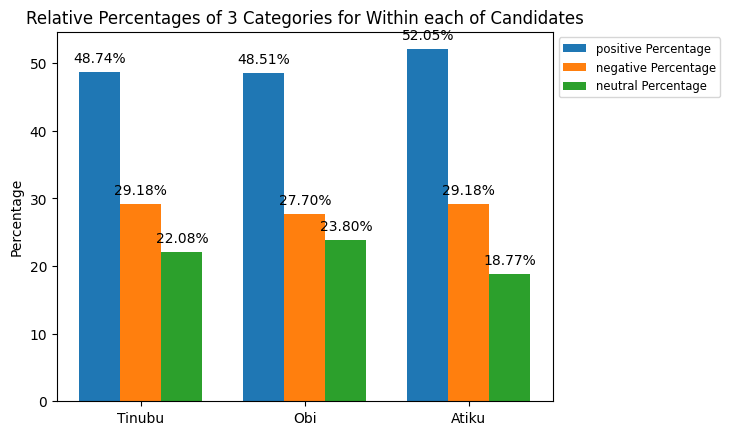

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# asisgns the candidates' name to a list
labels = ['Tinubu', 'Obi', 'Atiku']
categories = ['positive', 'negative', 'neutral']

#
data = np.array([
    [Tinubu_predicted_count['Positive'], Tinubu_predicted_count['Negative'], Tinubu_predicted_count['Neutral']],  # Tinubu
    [Obi_predicted_count['Positive'], Obi_predicted_count['Negative'], Obi_predicted_count['Neutral']],  # Obi
    [Atiku_predicted_count['Positive'], Atiku_predicted_count['Negative'], Atiku_predicted_count['Neutral']],  # Atiku
])

# Calculate overall percentages for each label
overall_percentages = np.sum(data, axis=1)

# Normalize data to get relative percentages
normalized_data = (data.T / overall_percentages).T * 100

# Plotting
fig, ax = plt.subplots()

# Plot stacked bar chart
bar_width = 0.25
bar_positions = np.arange(len(labels))

for i, category in enumerate(categories):
    ax.bar(bar_positions + i * bar_width, normalized_data[:, i], width=bar_width, label=f'{category} Percentage')

# Adding labels
ax.set_ylabel('Percentage')
ax.set_title('Relative Percentages of 3 Categories  Within each of Candidates')
ax.set_xticks(bar_positions + (len(categories) - 1) * bar_width / 2)
ax.set_xticklabels(labels)
legend = ax.legend(fontsize='small', bbox_to_anchor=(1, 1))  # Adjust bbox_to_anchor to position the legend

# Display percentages on top of bars
for i, bar_position in enumerate(bar_positions):
    for j, category in enumerate(categories):
        yval = normalized_data[i, j]
        ax.text(bar_position + j * bar_width, yval + 1, f'{yval:.2f}%', ha='center', va='bottom')

plt.show()